In [1]:
!pip install torchvision lightning albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 7.4 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import numpy as np

In [3]:
SOURCE2_DIR = '/kaggle/input/source2-detection'
SOURCE3_DIR = '/kaggle/input/source3-detection'

source3_train_pages = [os.path.join(SOURCE3_DIR, 'train', f) for f in os.listdir(os.path.join(SOURCE3_DIR, 'train'))]
source3_test_pages = [os.path.join(SOURCE3_DIR, 'test', f) for f in os.listdir(os.path.join(SOURCE3_DIR, 'test'))]
source3_validation_pages = [os.path.join(SOURCE3_DIR, 'validation', f) for f in os.listdir(os.path.join(SOURCE3_DIR, 'validation'))]

source3_test_annotations = os.path.join(SOURCE3_DIR, 'test_annotations.json')
source3_train_annotations = os.path.join(SOURCE3_DIR, 'train_annotations.json')
source3_validation_annotations = os.path.join(SOURCE3_DIR, 'validation_annotations.json')

source2_train_pages = [os.path.join(SOURCE2_DIR, 'train', f) for f in os.listdir(os.path.join(SOURCE2_DIR, 'train'))]
source2_test_pages = [os.path.join(SOURCE2_DIR, 'test', f) for f in os.listdir(os.path.join(SOURCE2_DIR, 'test'))]
source2_validation_pages = [os.path.join(SOURCE2_DIR, 'validation', f) for f in os.listdir(os.path.join(SOURCE2_DIR, 'validation'))]

source2_test_annotations = os.path.join(SOURCE2_DIR, 'test_annotations.json')
source2_train_annotations = os.path.join(SOURCE2_DIR, 'train_annotations.json')
source2_validation_annotations = os.path.join(SOURCE2_DIR, 'validation_annotations.json')

In [4]:
train_pages = np.array(source3_train_pages + source2_train_pages)
np.random.shuffle(train_pages)
validation_pages = np.array(source3_validation_pages + source2_validation_pages)
np.random.shuffle(validation_pages)

In [5]:
import json

def get_source2_annotation(img_id, json_path):
    with open(json_path, 'r') as f:
        annotations = json.loads(f.read())
        
    words = annotations[img_id]["words"]
    
    bboxes = [w['bbox'] for w in words]
    labels = [1 for i in range(len(words))]
    
    return bboxes, labels

def get_source3_annotation(img_id, json_path):
    with open(json_path, 'r') as f:
        annotations = json.loads(f.read())
        
    regions_contents = annotations[img_id]["regions_contents"]

    bboxes = []
    for rc in regions_contents:
        bboxes += rc['bboxes']

    labels = [1 for i in range(len(bboxes))]
    
    return bboxes, labels

train_annotations = {}
validation_annotations = {}

for page_path in train_pages:
    page_id = os.path.basename(page_path[:-4])
    if SOURCE2_DIR in page_path:
        bboxes, labels = get_source2_annotation(page_id, source2_train_annotations)
        if page_id not in [*train_annotations]:
            train_annotations[page_id] = {"bboxes": bboxes, "labels": labels}
        else:
            raise ValueError(f"Page with id: {page_id} is already in train annotations")
    
    elif SOURCE3_DIR in page_path:
        bboxes, labels = get_source3_annotation(page_id ,source3_train_annotations)
        if page_id not in [*train_annotations]:
            train_annotations[page_id] = {"bboxes": bboxes, "labels": labels}
        else:
            raise ValueError(f"Page with id: {page_id} is already in train annotations")
            
for page_path in validation_pages:
    page_id = os.path.basename(page_path[:-4])
    if SOURCE2_DIR in page_path:
        bboxes, labels = get_source2_annotation(page_id, source2_validation_annotations)
        if page_id not in [*validation_annotations]:
            validation_annotations[page_id] = {"bboxes": bboxes, "labels": labels}
        else:
            raise ValueError(f"Page with id: {page_id} is already in train annotations")
    
    elif SOURCE3_DIR in page_path:
        bboxes, labels = get_source3_annotation(page_id ,source3_validation_annotations)
        if page_id not in [*validation_annotations]:
            validation_annotations[page_id] = {"bboxes": bboxes, "labels": labels}
        else:
            raise ValueError(f"Page with id: {page_id} is already in train annotations")

In [6]:
test_pages = source3_test_pages + source2_test_pages
test_annotations = {}

for page_path in test_pages:
    page_id = os.path.basename(page_path[:-4])
    if SOURCE2_DIR in page_path:
        bboxes, labels = get_source2_annotation(page_id, source2_test_annotations)
        if page_id not in [*test_annotations]:
            test_annotations[page_id] = {"bboxes": bboxes, "labels": labels}
        else:
            raise ValueError(f"Page with id: {page_id} is already in train annotations")
    
    elif SOURCE3_DIR in page_path:
        bboxes, labels = get_source3_annotation(page_id ,source3_test_annotations)
        if page_id not in [*test_annotations]:
            test_annotations[page_id] = {"bboxes": bboxes, "labels": labels}
        else:
            raise ValueError(f"Page with id: {page_id} is already in train annotations")
            

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

def get_transform(train=True):
    if train:
        return A.Compose([
            # avg from 2 sources divided by 2
            A.Resize(height=678, width=946), 
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.5),
            ToTensorV2() 
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], clip=True))
    else:
        return A.Compose([
            A.Resize(height=678, width=946), 
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], clip=True))

def transform_image(image, bboxes, labels, train=True):
    transform = get_transform(train)
    transformed = transform(image=image, bboxes=bboxes, labels=labels)
    return transformed['image'], transformed['bboxes'], transformed['labels']

def load_image_and_apply_transform(image_path, bboxes, labels, train=True):
    image = np.array(Image.open(image_path).convert('L'))
    return transform_image(image, bboxes, labels, train)


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

class HandwritingDetectionDataset(Dataset):
    def __init__(self, image_paths, annotations, train=True):
        self.image_paths = image_paths
        self.annotations = annotations
        self.train = train
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_id = os.path.basename(image_path[:-4])
        bboxes = self.annotations[image_id]['bboxes']
        labels = self.annotations[image_id]['labels']
        
        image, bboxes, labels = load_image_and_apply_transform(image_path, bboxes, labels, self.train)
        target = {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }
        return image, target

def custom_collate_fn(batch):
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        targets.append(target)
    
    images = torch.stack(images).float()
    
    return images, targets

class DetectionDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "path/to/dir", batch_size: int = 8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_dataset = HandwritingDetectionDataset(
            train_pages, train_annotations, train=True)
        self.validation_dataset = HandwritingDetectionDataset(
            validation_pages, validation_annotations, train=False)
        self.test_dataset = HandwritingDetectionDataset(
            test_pages, test_annotations, train=False)


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)



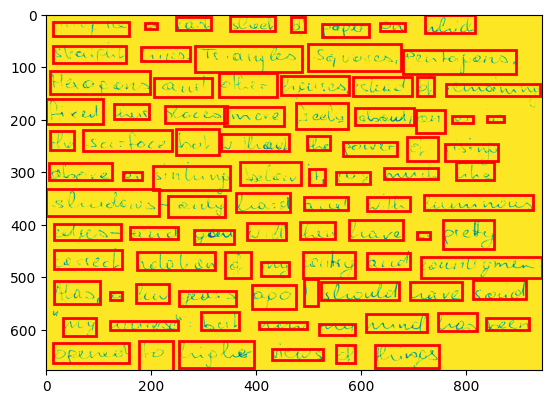

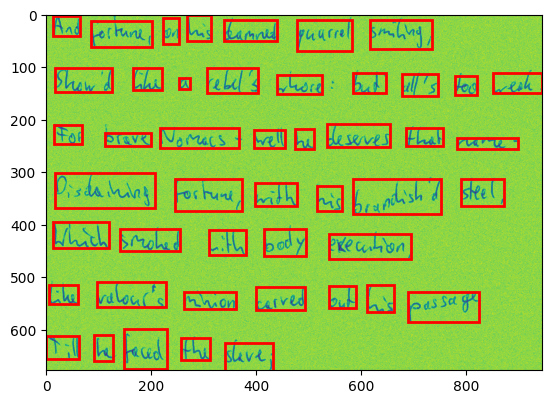

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader

def visualize_image_with_bboxes(image, bboxes, labels=None):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for i, bbox in enumerate(bboxes):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

#         if labels is not None:
#             ax.text(xmin, ymin - 2, f"Label: {labels[i]}", color='white', fontsize=12, backgroundcolor="red")

    plt.show()

def display_samples(dataset, num_samples=2):
    data_loader = DataLoader(dataset, batch_size=num_samples, shuffle=True, collate_fn=lambda x: x)
    
    batch = next(iter(data_loader))
    

    for image, target in batch:
        bboxes = target['boxes'].numpy() 
        labels = target['labels'].numpy() 
        visualize_image_with_bboxes(image, bboxes, labels)

display_samples(HandwritingDetectionDataset(
            train_pages, train_annotations, train=True), num_samples=2)


In [18]:
from typing import Any, Tuple, Union

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2


def compute_precision_recall(class_stats: dict) -> tuple[float, float, dict]:
    """
    Compute precision and recall.

    Parameters
    ----------
    class_stats : dict
        Statistics or information about different classes.

    Returns
    ----------
    Tuple[float, float]
        precision and recall
    """
    for _, stats in class_stats.items():
        precision = stats["tp"] / max(stats["tp"] + stats["fp"], 1)
        recall = stats["tp"] / max(stats["tp"] + stats["fn"], 1)

    return precision, recall, class_stats

def compute_confusion_matrix_elements(
    targets: list, detections: list, ious_threshold: float
) -> tuple[float, float, dict]:
    """
    Compute metrics (true positive, false positive, false negative) for object detection.

    Parameters
    ----------
    targets : list
        Ground truth annotations.
    detections : list
        Detected objects.
    ious_threshold  : float
        The threshold value for the intersection-over-union (IOU).
        Only detections whose IOU relative to the ground truth is above the
        threshold are true positive candidates.
    class_stats : dict
        Statistics or information about different classes.

    Returns
    ----------
    Tuple[float, float]
        precision and recall
    """
    class_stats = {"word": {"tp": 0, "fp": 0, "fn": 0}}
    for target, detection in zip(targets, detections):
        gt_boxes = target["boxes"]
        pred_boxes = detection["boxes"]
        pred_labels = detection["labels"]

        ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)

        max_ious, max_indices = ious.max(dim=1)

        # Identify true positives, false positives, and false negatives
        for idx, iou in enumerate(max_ious):
            if iou.item() > ious_threshold:
                pred_class_idx = pred_labels[idx].item()
                true_label = target["labels"][max_indices[idx]].item()

                if pred_class_idx == true_label:
                    class_stats["word"]["tp"] += 1
                else:
                    class_stats["word"]["fp"] += 1
            else:
                class_stats["word"]["fp"] += 1

        for target_box_index, target_box in enumerate(gt_boxes):
            found_match = False
            for idx, iou in enumerate(max_ious):
                if (
                    iou.item()
                    > ious_threshold  # we need this condition because the max overlap is not necessarily above the threshold
                    and max_indices[idx]
                    == target_box_index  # the matching index is the index of the GT box with which it has max overlap
                ):
                    # There's an IoU match and the matched index corresponds to the current target_box_index
                    found_match = True
                    break  # Exit loop, a match was found

            if not found_match:
                # print(found_match)
                class_stats["word"][
                    "fn"
                ] += 1  # Ground truth box has no corresponding detection

    precision, recall, class_stats = compute_precision_recall(class_stats)

    return precision, recall, class_stats

class HandwritingDetectionModel(pl.LightningModule):
    """
    LightningModule implementation of Faster R-CNN for object detection.

    Parameters
    ----------
    config : dict
        Configuration settings for the model.

    Methods
    -------
    forward(x):
        Forward pass of the model.
    training_step(batch, batch_idx):
        Defines the training step for the model.
    configure_optimizers():
        Configures the optimizer for training.

    Attributes
    ----------
    config : dict
        Configuration settings for the model.
    model : torch.nn.Module
        Faster R-CNN model.
    training_step_outputs : dict
        Dictionary to store training metrics.
    validation_step_outputs : dict
        Dictionary to store validation metrics.
    test_step_outputs : dict
        Dictionary to store test metrics.
    """

    def __init__(self, config: dict[str, Any], opt_logs=True):
        super().__init__()
        self.config = config
        self.model = self.configure_model()
        self.opt_logs = opt_logs

        # save all arguments passed to __init__
        self.save_hyperparameters()

        # metrics to log during training/val/test loop
        self.training_step_outputs = {
            "training_loss_epoch": 0.0,
            "num_batches": 0,
        }
        self.validation_step_outputs = {
            "precision_epoch": 0.0,
            "recall_epoch": 0.0,
            "num_batches": 0,
        }
        self.test_step_outputs = {
            "precision_epoch": 0.0,
            "recall_epoch": 0.0,
            "num_batches": 0,
        }

    def configure_model(self) -> torch.nn.Module:
        """
        Configures the Faster R-CNN model for HT detection
        """
        model = fasterrcnn_resnet50_fpn_v2(num_classes=2, box_detections_per_img=200)
        return model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        """
        return self.model(x)

    def accumulate_epoch_metrics(
        self,
        batch_output: dict,
        dataset_str: str,
    ) -> None:
        """
        Accumulates precision and recall metrics per epoch.
        """
        getattr(self, f"{dataset_str}_step_outputs")[
            "precision_epoch"
        ] += batch_output["precision"]

        getattr(self, f"{dataset_str}_step_outputs")[
            "recall_epoch"
        ] += batch_output["recall"]

        getattr(self, f"{dataset_str}_step_outputs")["num_batches"] += 1

    def compute_precision_recall_epoch(
        self, step_outputs: dict[str, Union[float, int]], log_str: str
    ) -> Tuple[float, float]:
        """
        Computes and logs mean precision and recall for the current epoch.
        """

        # compute mean precision and recall
        mean_precision = (
            step_outputs["precision_epoch"] / step_outputs["num_batches"]
        )
        mean_recall = (
            step_outputs["recall_epoch"] / step_outputs["num_batches"]
        )

        # add metrics to logger
        self.log_dict(
            {f"{log_str}_precision": mean_precision}, on_epoch=True, sync_dist=True
        )
        self.log_dict(
            {f"{log_str}_recall": mean_recall}, on_epoch=True, sync_dist=True
        )


        return mean_precision, mean_recall

    def on_train_epoch_end(self) -> None:
        """
        Hook called after each training epoch to perform tasks such as logging and resetting metrics.
        """
        # compute average loss
        avg_loss = (
            self.training_step_outputs["training_loss_epoch"]
            / self.training_step_outputs["num_batches"]
        )

        # log
        self.log_dict(
            {"train_loss": avg_loss}, on_epoch=True, sync_dist=True
        )

        # reset
        self.training_step_outputs = {
            "training_loss_epoch": 0.0,
            "num_batches": 0,
        }

    def on_validation_epoch_end(self) -> None:
        """
        Hook called after each validation epoch to compute metrics and logging.
        """
        (val_precision, val_recall) = self.compute_precision_recall_epoch(
            self.validation_step_outputs, "val"
        )

        # we need these logs for hyperparameter optimisation
        if self.opt_logs:
            self.log("val_precision", val_precision, on_epoch=True, sync_dist=True)
            self.log("val_recall", val_recall, on_epoch=True, sync_dist=True)

        # Reset metrics for next epoch
        self.validation_step_outputs = {
            "precision_epoch": 0.0,
            "recall_epoch": 0.0,
            "num_batches": 0,
        }

    def on_test_epoch_end(self) -> None:
        """
        Hook called after each testing epoch to compute metrics and logging.
        """
        (test_precision, test_recall) = self.compute_precision_recall_epoch(
            self.test_step_outputs, "test"
        )

        # Reset metrics for next epoch
        self.test_step_outputs = {
            "precision_epoch": 0.0,
            "recall_epoch": 0.0,
            "num_batches": 0,
        }

    def training_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        """
        Defines the training step for the model.
        """
        images, targets = batch
        loss_dict = self.model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        self.training_step_outputs["training_loss_epoch"] += total_loss.item()
        self.training_step_outputs["num_batches"] += 1

        return total_loss

    def val_test_step(
        self, batch: tuple[torch.Tensor, torch.Tensor]
    ) -> dict[str, Union[float, int]]:
        """
        Performs inference on a validation or test batch and computes precision and recall.
        """
        images, targets = batch
        predictions = self.model(images)

        precision, recall, _ = compute_confusion_matrix_elements(
            targets, predictions, self.config["iou_threshold"]
        )
        return {"precision": precision, "recall": recall}

    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict[str, Union[float, int]]:
        """
        Defines the validation step for the model.
        """
        outputs = self.val_test_step(batch)
        self.accumulate_epoch_metrics(outputs, "validation")
        return outputs

    def test_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict[str, Union[float, int]]:
        """
        Defines the test step for the model.
        """
        outputs = self.val_test_step(batch)
        self.accumulate_epoch_metrics(outputs, "test")
        return outputs

    def configure_optimizers(self) -> dict[str, torch.optim.Optimizer]:
        """
        Configures the optimizer for training.
        """
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.config["learning_rate"],
            weight_decay=self.config["wdecay"],
        )
        return {"optimizer": optimizer}


In [19]:
from torch.optim import Adam
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

from lightning.pytorch.profilers import SimpleProfiler
from pytorch_lightning.callbacks import EarlyStopping, Callback

class MyPrintingCallback(Callback):
    def __init__(self):
        super().__init__()

    def on_train_start(self, trainer, pl_module):
        print("Starting to train!")

    def on_train_end(self, trainer, pl_module):
        print("Training is done.")
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        print(loss_dict)
        total_loss = sum(self.loss_weights[key] * value for key, value in loss_dict.items())

        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log_dict({f'train_{key}': value for key, value in loss_dict.items()}, on_step=True, on_epoch=True, sync_dist=True)

        return total_loss
    
    def configure_optimizers(self):
        return Adam(self.model.parameters(), lr=1e-4)

model = HandwritingDetectionModel({"wdecay": 1e-4, "learning_rate": 1e-4,  "iou_threshold": 0.6})

dm = DetectionDataModule()

NUM_EPOCHS = 20
ACCELERATOR = "gpu"
DEVICES = [0, 1]
PRECISION = "bf16-mixed"

trainer = pl.Trainer(
    strategy='ddp_notebook',
    accelerator=ACCELERATOR,
    devices=DEVICES,
    min_epochs=1,
    max_epochs=NUM_EPOCHS,
    precision=PRECISION,
    callbacks=[MyPrintingCallback(), EarlyStopping(monitor="val_loss")],
    default_root_dir="/kaggle/working/",
    max_time="00:06:00:00",
    profiler=SimpleProfiler(),
)

trainer.fit(model, dm)
# trainer.validate(model, dm)
# trainer.test(model, dm)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



Starting to train!Starting to train!



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_precision', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_recall', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
INFO: `Trainer.fit` stopped: `max_steps=1` reached.


Training is done.
Training is done.


INFO: FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  172        